<a href="https://colab.research.google.com/github/davidkant/mai/blob/master/tutorial/7_2_Timbre_Remix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7.2 Timbre / Remix
As we saw (or rather, heard) with the **7.1 The Speaking Piano**, there's a lot more to sound than just pitch. We can think of any sound as being made up of many different frequencies, and the relative amplitudes of all of these different frequencies is what makes a given sound sound like itself — like a piano, or a saxophone, or a human voice. At this point, you're probably pretty familiar with the words pitch and loudness, but what else is there to describe about sound? Lots of things! Sounds can be "dark," "bright," "soft," "rough," and much much  more. Unfortunately, all of this other stuff is generally lumped into one exceptionally inarticulate word, [***timbre***](https://en.wikipedia.org/wiki/Timbre), as it's used to refer to *all* of the sonic qualities that *are not* pitch and loudness — if that doesn't tell you something about priorities in Western musical systems then... In this notebook we'll take a closer look at the spectrum and the concept of timbre.


# Setup

In [0]:
# install external libraries
from IPython.display import clear_output
!pip install -q git+https://github.com/davidkant/mai#egg=mai;
!apt-get -qq update
!apt-get -qq install -y libfluidsynth1
!git clone https://github.com/davidkant/mai.git
clear_output()

    100% |████████████████████████████████| 11.0MB 3.5MB/s 
Selecting previously unselected package libfluidsynth1:amd64.
(Reading database ... 131284 files and directories currently installed.)
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Cloning into 'mai'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 649 (delta 54), reused 58 (delta 28), pack-reused 562
Receiving objects: 100% (649/649), 23.59 MiB | 20.79 MiB/s, done.
Resolving deltas: 100% (387/387), done.


In [0]:
# imports
import mai
import librosa
from librosa import display
import functools
import numpy as np
import IPython.display as ipyd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

Using TensorFlow backend.


# Load a soundfile
Load a soundfile to work with.

In [0]:
filename = 'mai/resources/audio/rollersample.wav'
y, sr = librosa.load(filename, sr=None)

# Hello Spectrogram

First let's plot the waveform. Do you have any idea what this sounds like?

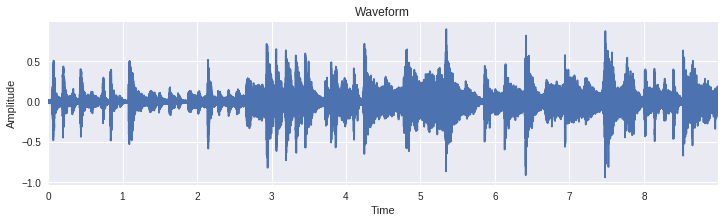

In [0]:
plt.figure(figsize=(12,3))
plt.plot(np.arange(len(y))/float(sr), y)
plt.title('Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.xlim([0,len(y)/float(sr)])
plt.show()

Now let's plot the spectrogram. Compute it using ` mai.listen.spectrogram()` and store it in the variable `S`.

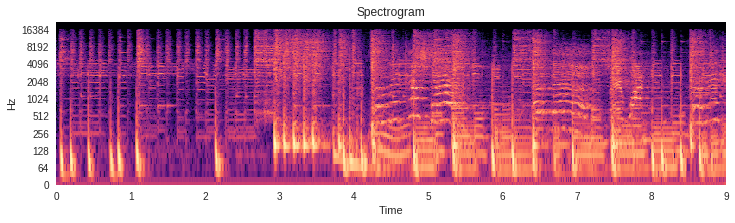

In [0]:
# compute spectrogram
S = mai.listen.spectrogram(y)

# plot spectrogram
plt.figure(figsize=(12,3))
librosa.display.specshow(S, x_axis='time', y_axis='log', sr=sr)
plt.title('Spectrogram')
plt.show()

A spectrogram represents the frequency content of sound. **Time** is still across the horizontal axis from left to right, but now the vertical axis represents **frequency**, and color represents the **intensity** or loudness at each time-frequency point. 

How do the waveform and spectrogram plots compare? The idea is that the spectrogram represents sound in a way that is arguably more meaningul to human perception. Just looking at the spectrogram, for insance, I see that the clip starts with a few sporadic low frequency events, the squiggly lines in the second half of the clip are characteristic of singing voice, the bright, skinny vertical lines are probably percussive events, like drums, since they have a loud, noisy onset and quick decay, and I swear, if I stare closely enough at the bottom of the spectrogram in the second half of the clip, I can see a low frequency melody, perhaps a bass line? Go ahead and listen.

In [0]:
ipyd.Audio(y, rate=sr)

### Now entering the second dimension...
Since spectrograms have two dimensions — both frequency and intensity over time — we need a new datastructure to represent it (a list won't do). Spectrograms are typically represented by [matrices](https://en.wikipedia.org/wiki/Matrix_(mathematics), which you can think of as a rectangular grid or array of numbers. Just imagine overlaying a rectangular grid on that spectrogram above. Each location on the grid corresponds to a particular frequency and a particular moment in time. The value at that location is the amount of energy.

What else is typically represented using matrices? ... images! So yes, you can kind of think of a sepctrogram as kind of sound image. And, even better, many image processing algorithms have similar and/or interesting results when applied to spectrograms. You may even be tempted to go find an image, interpret it as a spectrogram, and turn it into sound...

It's important to remember which dimension is which. In our case, the first dimension is frequency, and the second dimension is time (in frames). Call `S.Shape` to see how big the matrix is. This one has `1025` frequency values and `775` time values.

In [0]:
S.shape

(1025, 775)

# Spectral Features
Clearly "everything else" is important, but how do we describe it? One answer: ***spectral features***. Spectral features quantify and numerically express aspects of the spectrum. There's a whole pile of them, such as *spectral centroid*, or *spectral skewness*, or, and this is my favorire, *spectral kurtosis*. Spectral features measure different qualities of the "shape" of the spectrogram, often using higher order statistics — see [kurtosis](https://en.wikipedia.org/wiki/Kurtosis). 

The spectral centroid, for example, measures the "center of gravity" of the spectrum — whether it is composed of higher or lower frequencies — and tends to correspond with the perception of "brightness" or "sharpness." It is computed as the mean average frequency weighted by magnitude. The spectral spread characterizes how a spectrum is distributed around its centroid — whether it is concentrated near the centroid or distributed across a wider range of frequencies — and tends to correspond, perceptually, with distinguishing pure tones from noise-like sounds. Statistically speaking, it is the second moment of the spectrum, and is computed by taking the root-mean-square deviation of the spectrum from its centroid. 

Now you understand why if you walk into a recording session and ask for "more spectral centroid" you may receive some funny looks.

## Extracting spectral features 
Let's try to understand this on a more intuitive level, using our eyes and ears. You can exatrct a collection of spectral features from an audiofile using the function `spectral_features(y)`, which returns a `dictionary` of `(key, value)` pairs, where the `key` is the feature name and the `value` is the feature data.

In [0]:
features = mai.listen.spectral_features(y)

Print the names of the features extracted. 

In [0]:
features.keys()

dict_keys(['lowlevel.spectral_centroid', 'lowlevel.spectral_complexity', 'lowlevel.spectral_crest', 'lowlevel.spectral_decrease', 'lowlevel.spectral_energy', 'lowlevel.spectral_energyband_high', 'lowlevel.spectral_energyband_low', 'lowlevel.spectral_energyband_middle_high', 'lowlevel.spectral_energyband_middle_low', 'lowlevel.spectral_entropy', 'lowlevel.spectral_flatness_db', 'lowlevel.spectral_flux', 'lowlevel.spectral_kurtosis', 'lowlevel.spectral_rms', 'lowlevel.spectral_rolloff', 'lowlevel.spectral_skewness', 'lowlevel.spectral_spread', 'lowlevel.spectral_strongpeak'])

Let's plot one. Copy and paste other feature names into the first line to see more.

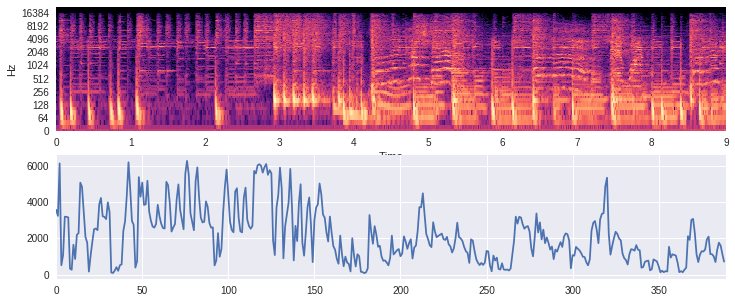

In [0]:
# feature to plot
feature = features['lowlevel.spectral_centroid']

# plot spectrogram
plt.figure(figsize=(12,5))
ax1 = plt.subplot(2, 1, 1)
librosa.display.specshow(S, x_axis='time', y_axis='log', sr=sr)

# plot feature
plt.subplot(2, 1, 2)
plt.xlim([0,feature.shape[0]])
plt.plot(feature)
plt.show()

ipyd.Audio(y, rate=sr)

Plot *all* of the specral features extracted.

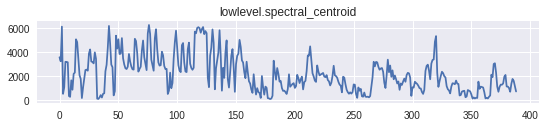

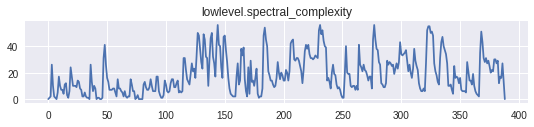

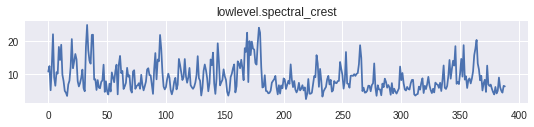

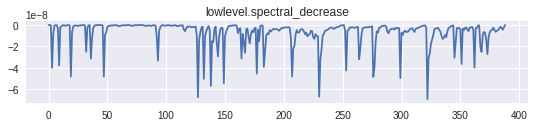

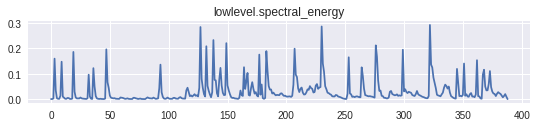

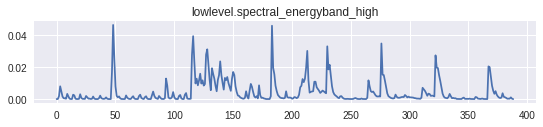

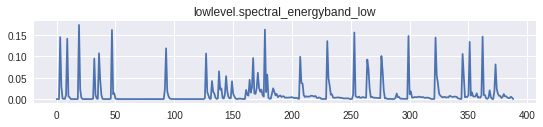

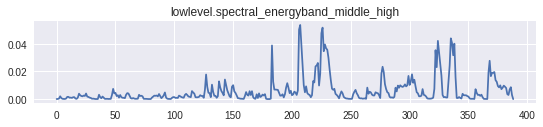

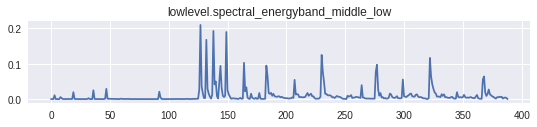

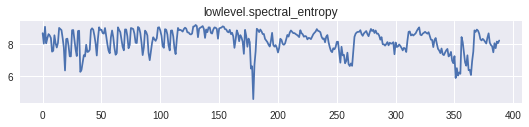

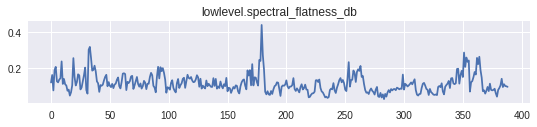

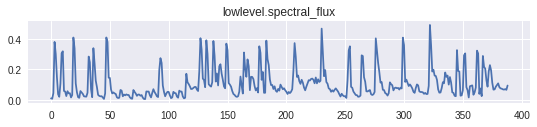

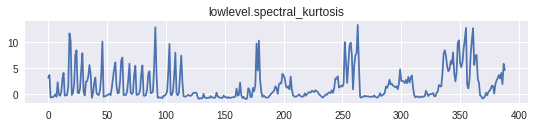

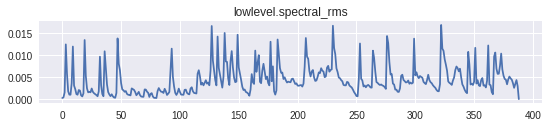

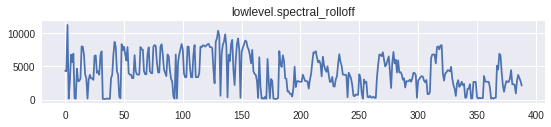

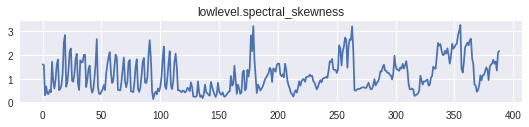

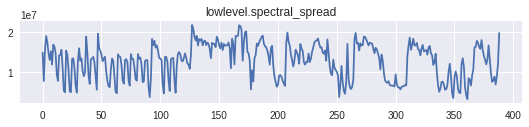

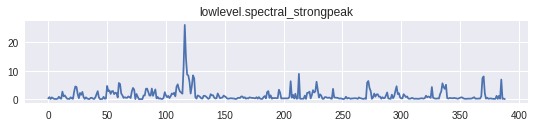

In [0]:
for (feature_name, feature_data) in features.items():
  plt.figure(figsize=(9,1.5))
  plt.plot(feature_data)
  plt.title(feature_name)
  plt.show()

# Let's remix some music
This is all pretty abstract, so let's hear something. What if we cut up this sound file into tiny pieces and rearrange those tiny pieces sorted by some spectral feature, from low to high. We'll start with the spectral centroid.

In [0]:
# select feature to sort by here
feature_name = 'lowlevel.spectral_centroid'

# get feature data
feature_data = features[feature_name]

Remix the original audio by cutting it into tiny pieces and sorting those low to high.

In [0]:
# don't worry about the code in this cell
rearranged = np.zeros(0)

for frame in np.argsort(feature_data):
  hopSize = 1024
  frameSize = 2048
  start_time = int(frame*hopSize - frameSize/2)
  end_time = int(frame*hopSize + frameSize/2)
  rearranged = np.concatenate((rearranged, y[start_time:end_time]))
    
rearranged = np.concatenate((np.zeros(1024),rearranged))

Listen. Let's also plot the rearranged audio as a sanity check.

In [0]:
features_hat = mai.listen.spectral_features(rearranged)

# feature to plot
feature_hat = features_hat[feature_name]

# plot spectrogram
plt.figure(figsize=(12,5))
ax1 = plt.subplot(2, 1, 1)
librosa.display.specshow(mai.listen.spectrogram(rearranged), x_axis='time', y_axis='log', sr=sr)
plt.title('{} from low to high'.format(feature_name))

# plot feature
plt.subplot(2, 1, 2)
plt.xlim([0,feature_hat.shape[0]])
plt.plot(feature_hat)
plt.show()

# listen
ipyd.Audio(rearranged, rate=sr)

**Try it:** Go back and try a few different features by changing the value of `feature_name` in the first line.